## Encoder Distillation

In [ ]:
import sys
sys.path.append("..")
from pathlib import Path
from tqdm import tqdm

import torch
from transformers import (SamModel, SamProcessor)
from utils.mobile_sam import sam_model_registry
from utils.mobile_sam.predictor import SamPredictor

from utils.datasets import SA1B_Dataset
from utils.utils import *

%load_ext autoreload
%autoreload 2

In [ ]:
# Config
DATA_DIR = Path('../Datasets/')
GPU = 3

DEVICE = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dataset
dataset = SA1B_Dataset(root=DATA_DIR.joinpath('SA_1B/images/'), features=None, split='sa_000009')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
len(dataset)

In [ ]:
for j, (i, l, n) in enumerate(dataloader):
    print(i.shape, l.shape, n)
    if j > 10:
        break

In [ ]:
print(len(l.unique()))
plt.imshow(l[0])
plt.show()

In [ ]:
# Teacher
teacher = SamModel.from_pretrained("facebook/sam-vit-huge").to(DEVICE).eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [ ]:
# Student
model_type = "vit_t"
sam_checkpoint = "bin/mobile_sam.pt"

model = sam_model_registry[model_type](checkpoint=None).to(DEVICE).train()
student = SamPredictor(model)

In [ ]:
with torch.no_grad():
    inputs = processor(i, input_points=None, return_tensors="pt").to(DEVICE)
    t_features = teacher.get_image_embeddings(inputs["pixel_values"]).cpu()

In [ ]:
# mse
mse = torch.nn.MSELoss()
mse(t_features, l)

In [ ]:
l

In [ ]:
t_features

In [ ]:
class Distiller():
    def __init__(self, teacher, student, processor, dataloader, optimizer, device):
        self.teacher = teacher
        self.student = student
        self.processor = processor
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.device = device

    def get_distillation_loss(self, img):
        student.set_image(img[0].permute((2,0,1)))
        s_features = student.features

        with torch.no_grad():
            inputs = processor(img, input_points=None, return_tensors="pt").to(DEVICE)
            t_features = teacher.get_image_embeddings(inputs["pixel_values"])

        return torch.nn.functional.mse_loss(s_features, t_features)

    def distill(self):
        t = tqdm(dataloader, desc='Distillation:')
        for img, _, _ in t:
            self.optimizer.zero_grad()
            loss = self.get_distillation_loss(img)
            loss.backward()
            self.optimizer.step()
            t.set_postfix({'Loss': loss.item()})

In [ ]:
optimizer = torch.optim.Adam(student.model.parameters(), lr=1e-3)
distiller = Distiller(teacher, student, processor, dataloader, optimizer, DEVICE)

In [ ]:
distiller.distill()

In [ ]:
torch.save(distiller.student.model.state_dict(), 'bin/distilled_mobile_sam.pt')

In [ ]:
import csv

In [ ]:
teacher_features_ids = csv.reader(open(Path('results/feature_ids.csv'), 'r'))
l = list(teacher_features_ids)
#l = [i[0] for i in l]
len(l)

In [ ]:
l[:5]

In [ ]:
f = torch.load('results/teacher_features.pt')

In [ ]:
len(f)

## Decoder Distillation

- prompt a random point belonging to an instance
- get the corresponding mask and mask size
- use saved SAM features
- freeze MobileSAM backbone
- prompt SAM and MobileSAM and collect output masks (3 masks?)
- compute dice and focal loss (20:1)
- weight loss based on mask size
- OBTAIN LOGITS FROM (MOBILESAM, SAM) !!! (return_logits=True, binarize=False)

In [ ]:
# get_prompt()
# get_instance_label()
# get_mask_size()
# size coefficient = 1 - (mask_size / image_size)
# get_output(SAM, saved_features, prompt)
# get_output(MobileSAM, saved_features, prompt) 
# dice_loss()
# focal_loss()
# loss = (20 * dice_loss() + focal_loss()) * size_coefficient

In [ ]:
from distillation import *

In [ ]:
DATA_DIR = Path('../Datasets/')
SPLIT = 'sa_000020'
GPU = 2
DEVICE = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 8
SHUFFLE = True
LOAD_FEATURES = True
FEATURES = 'results/teacher_features.pt' if LOAD_FEATURES else None

EPOCHS = 16
LR = 1e-3
OPTIM = 'adamw'
WD = 1e-5
LOSS_WEIGHTS = [0,0,1,0] # 20 focal, 1 dice, 0 bce, 0 size

MODE = 'decoder' # encoder, decoder, save_features
PRETRAINED = True if MODE == 'decoder' else False

dataset = SA1B_Dataset(root=DATA_DIR.joinpath('SA_1B/images/'), split=SPLIT,  features=FEATURES, labels=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=SHUFFLE, num_workers=16, pin_memory=True)

teacher = SamModel.from_pretrained("facebook/sam-vit-huge").to(DEVICE)
teacher.eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

model_type = "vit_t"
sam_checkpoint = "bin/mobile_sam.pt" if PRETRAINED else None

model = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
model.eval()
for m in model.image_encoder.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        m.weight.requires_grad_(False)
        m.bias.requires_grad_(False)
student = SamPredictor(model)

if MODE == 'encoder':
    DISTILLER = EncDistiller
    params = student.model.image_encoder.parameters()
else:
    DISTILLER = DecDistiller
    params = student.model.mask_decoder.parameters()

if OPTIM == 'adamw':
    optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
elif OPTIM == 'adam':
    optimizer = torch.optim.Adam(params, lr=LR)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

distiller = DISTILLER(teacher, student, processor, dataloader, optimizer, scheduler, loss_weights=LOSS_WEIGHTS, device=DEVICE)

if MODE == 'save_features':
    distiller.save_teacher_features(Path('results/teacher_features.pt'))
else:
    distiller.distill(epochs=EPOCHS, accumulate=BATCH_SIZE, use_saved_features=LOAD_FEATURES, name=MODE)

## Profiler

In [ ]:
import sys
from pstats import Stats

filename = '../results/profile.prof' 
my_stat = Stats(filename, stream=sys.stdout).sort_stats('time')
my_stat.print_stats(.1)
print()

## Distiller Inspection

In [ ]:
import sys
sys.path.append("..")
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from transformers import (SamModel, SamProcessor)
from utils.mobile_sam import sam_model_registry
from utils.mobile_sam.predictor import SamPredictor
from utils.datasets import SA1B_Dataset
from utils.utils import *
from utils.distill_utils import *

from ipywidgets import Button
import asyncio
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In [ ]:
def wait_for_change(widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget.on_click(getvalue, remove=True) 
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    widget.on_click(getvalue)
    return future

class InspectDistiller(DecDistiller):
    def __init__(self, teacher, student, processor, dataloader, test_dataloader, optimizer, scheduler, loss_weights=[0,0,0,0,1,0], 
                 n_prompts=1, random_prompt=True, edge_filter=True, size_thr=0, profile=False, device='cuda', button=None):
        super().__init__(teacher, student, processor, dataloader, test_dataloader, optimizer, scheduler, loss_weights, 
                         n_prompts, random_prompt, edge_filter, size_thr, profile, device)
        self.BUTTON = button
        
    '''
    def get_loss(self, t_mask, s_mask, label):
        t_mask_bin = (t_mask > 0.0)
        focal = self.focal_loss(s_mask, t_mask_bin.float())
        bce = self.bce_loss(s_mask, t_mask_bin.float())
        iou = self.iou_loss(s_mask, t_mask_bin.int())
        dice = self.dice_loss(s_mask, t_mask_bin.int())
        #bce_gt = self.bce_loss(s_mask, label.float())
        #iou_gt = self.iou_loss(s_mask, label.int())
        #bound = self.bound_loss(s_mask, label.int())
        return focal, bce, iou, dice

    def get_prompt(self, label, seed=None):
        C, counts = np.unique(label.cpu(), return_counts=True)
        counts = counts / counts.sum()
        C = C[counts > 0.001]
        # print(C)
        if seed is not None:
            np.random.seed(seed)
        c = np.random.choice(C)

        x_v, y_v = np.where(label.cpu() == c)
        if self.random_prompt:
            if seed is not None:
                random.seed(seed)
            r = random.randint(0, len(x_v) - 1)
            x, y = x_v[r], y_v[r]
        else: # central prompt
            x, y = x_v.mean(), y_v.mean()
            x, y = int(x), int(y)
        return [[[y,x]]], c # inverted to compensate different indexing
    '''

    def training_step(self, i, img, label, feats, acc, use_saved_features=False):
        feats = feats.to(self.device) if use_saved_features else None
        self.get_features(img)
        prompts = self.get_prompts(label[0], seed=8)
        label = label.to(self.device)
        # print(prompts)

        for prompt, c in prompts:
            # show_points_on_image(img[0], prompt[0], np.array([1]), title='Prompt') 
            # show_points_on_image((label[0]==c).cpu().numpy(), prompt[0], np.array([1]), 
            #                      title=f'GT size:{(label[0]==c).cpu().numpy().sum()}')
            t_mask, s_mask = self.get_masks(img, prompt, feats)
            focal, bce, iou, dice = self.get_loss(t_mask, s_mask, label[0]==c)
            loss = (self.FW * focal + self.BW * bce + self.IW * iou) / acc
            loss.backward(retain_graph=True)
            # print(f"GT  BCE: {bce_gt.item():.2e} IoU: {iou_gt.item():.2e}")
            show_points_on_image(t_mask.cpu().numpy(), prompt[0], np.array([1]), title='Teacher Raw')
            show_points_on_image(s_mask.detach().cpu().numpy(), prompt[0], np.array([1]), title='Student Raw') 
            show_points_on_image((t_mask>0).cpu().numpy(), prompt[0], np.array([1]), title='Teacher Mask') 
            show_points_on_image((s_mask>0).detach().cpu().numpy(), prompt[0], np.array([1]), title='Student Mask') 
            print(f"BCE: {bce.item():.2e} IoU: {iou.item():.2e} Focal: {focal.item():.2e} Dice: {dice.item():.2e}")
            self.update_metrics(loss, focal, bce, iou, dice)

        if (i+1) % acc == 0 or i+1 == len(self.dataloader):
            print(f"BCE: {self.r_bce/(i+1):.2e} IoU: {self.r_iou/(i+1):.2e} Focal: {self.r_focal/(i+1):.2e} Dice: {self.r_dice/(i+1):.2e}")
            self.optimizer.step()
            self.optimizer.zero_grad()

    async def distill(self, epochs=8, acc=4, use_saved_features=False, name=''):
        self.acc = acc
        self.student.model.mask_decoder.train()
        self.student.model.prompt_encoder.train()
        self.student.model.image_encoder.eval()

        self.init_metrics()
        for i, (img, label, _, feats) in enumerate(self.dataloader):
            self.training_step(i, img, label, feats, acc, use_saved_features)
            print('Waiting for button click...')
            _ = await wait_for_change(self.BUTTON)
            clear_output(wait=True)
            print('Button clicked!')
            break

        self.validate(use_saved_features=use_saved_features)

    def validate(self, use_saved_features=False):
        self.student.model.mask_decoder.eval()
        self.student.model.prompt_encoder.eval()
        self.student.model.image_encoder.eval()

        with torch.no_grad():
            r_iou = 0
            for img, label, _, feats in self.test_dataloader:
                feats = feats.to(self.device) if use_saved_features else None
                self.get_features(img)
                prompt, c = self.get_prompt(label[0], seed=0)
                label = label.to(self.device)

                t_mask, s_mask = self.get_masks(img, prompt, feats)
                
                show_points_on_image(t_mask.cpu().numpy(), prompt[0], np.array([1]), title='Teacher Raw')
                show_points_on_image(s_mask.detach().cpu().numpy(), prompt[0], np.array([1]), title='Student Raw') 
                show_points_on_image((t_mask>0).cpu().numpy(), prompt[0], np.array([1]), title='Teacher Mask') 
                show_points_on_image((s_mask>0).detach().cpu().numpy(), prompt[0], np.array([1]), title='Student Mask') 

                focal, bce, iou, dice = self.get_loss(t_mask, s_mask, label[0]==c)
                loss = self.FW * focal + self.BW * bce + self.IW * iou + self.DW * dice

                iou = self.get_metrics(t_mask, s_mask, label[0]==c)
                r_iou += iou
                print(f"Loss: {loss.item():.2e} BCE: {bce.item():.2e} IoU: {iou:.2e} Focal: {focal.item():.2e} Dice: {dice.item():.2e}")
                #print('Waiting for button click...')
                #_ = await wait_for_change(self.BUTTON)
                #clear_output(wait=True)
                #print('Button clicked!')

            return r_iou / len(self.test_dataloader)

In [ ]:
with open('../config.yaml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

cfg['DATA_DIR'] = Path('../' + cfg['DATA_DIR'])
cfg['DEVICE'] = torch.device(f"cuda:{cfg['GPU']}" if torch.cuda.is_available() else "cpu")
cfg['PRETRAINED'] = True if cfg['MODE'] == 'decoder' else False
DISTILLER = InspectDistiller

In [ ]:
dataset = SA1B_Dataset(root=cfg['DATA_DIR'].joinpath('SA_1B/images/'), split=["sa_00000" + str(i) for i in range(cfg['TRAIN_SPLITS'])],
                        features=None, labels=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=cfg['SHUFFLE'], num_workers=cfg['NUM_WORKERS'], pin_memory=False)
test_dataset = SA1B_Dataset(root=cfg['DATA_DIR'].joinpath('SA_1B/images/'), split=[cfg['SPLIT']], 
                            features=None, labels=True, max=cfg['MAX_TEST'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=cfg['NUM_WORKERS'], pin_memory=False)

teacher = SamModel.from_pretrained("facebook/sam-vit-huge").to(cfg['DEVICE'])
teacher.eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

sam_checkpoint = "../bin/mobile_sam.pt" if cfg['PRETRAINED'] else None
model = sam_model_registry["vit_t"](checkpoint=sam_checkpoint, size_embedding=cfg['SIZE_EMBEDDING']).to(cfg['DEVICE'])
model.eval()
for m in model.image_encoder.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        m.weight.requires_grad_(False)
        m.bias.requires_grad_(False)
student = SamPredictor(model)

params = list(student.model.mask_decoder.parameters()) + list(student.model.prompt_encoder.parameters())

if cfg['OPTIM'] == 'adamw':
    optimizer = torch.optim.AdamW(params, lr=cfg['LR'], weight_decay=cfg['WD'])
if cfg['SCHEDULER'] == 'cos':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg['EPOCHS'], eta_min=1.0e-7)

In [ ]:
distiller = DISTILLER(teacher, student, processor, dataloader, test_dataloader, optimizer, scheduler, loss_weights=cfg['LOSS_WEIGHTS'], 
                      n_prompts=cfg['N_PROMPTS'], random_prompt=cfg['RANDOM_PROMPT'], edge_filter=cfg['EDGE_FILTER'], size_thr=cfg['SIZE_THR'],
                      profile=cfg['PROFILE'], device=cfg['DEVICE'], button=Button(description='step()'))

In [ ]:
asyncio.create_task(distiller.distill(epochs=cfg['EPOCHS'], acc=cfg['BATCH_SIZE'],
use_saved_features=cfg['LOAD_FEATURES'], name=f"{cfg['MODE']}_{cfg['EXP']}"))
#asyncio.create_task(distiller.validate(use_saved_features=cfg['LOAD_FEATURES']))
distiller.BUTTON

In [ ]:
distiller.BUTTON

## SAM in MobileSAM Test

In [ ]:
DEVICE = 7
import matplotlib.pyplot as plt
import numpy as np
from utils.mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import pipeline, SamModel, SamProcessor

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.4])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=False)
  plt.axis("off")
  plt.show()
  del mask

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
# Original SAM
SAM = SamModel.from_pretrained("facebook/sam-vit-huge").to(DEVICE)
SAM.eval()
SAM_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
SAM_gen = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)

# MobileSAM's SAM
model_type = "vit_h"
sam_checkpoint = "../bin/sam_vit_h_4b8939.pth"
TEST = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
TEST.eval()
TEST_processor = SamPredictor(TEST)
TEST_gen = SamAutomaticMaskGenerator(TEST)

# MobileSAM's MobileSAM
model_type = "vit_t"
sam_checkpoint = "../bin/mobile_sam.pt"
MOBILESAM = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
MOBILESAM.eval()
MOBILESAM_processor = SamPredictor(MOBILESAM)
MOBILESAM_gen = SamAutomaticMaskGenerator(MOBILESAM)

In [ ]:
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

In [ ]:
outputs = SAM_gen(raw_image, points_per_batch=64)
masks = outputs["masks"]
show_masks_on_image(raw_image, masks)

In [ ]:
sam_masks = TEST_gen.generate(np.array(raw_image))
sam_masks = [m['segmentation'] for m in sam_masks]
show_masks_on_image(raw_image, sam_masks)

In [ ]:
mobilesam_masks = MOBILESAM_gen.generate(np.array(raw_image))
mobilesam_masks = [m['segmentation'] for m in mobilesam_masks]
show_masks_on_image(raw_image, mobilesam_masks)

In [ ]:
mae = []
for s, m in zip(sam_masks, mobilesam_masks):
    s = s.astype(float)
    m = m.astype(float)
    e = np.mean((s-m)**2)
    mae.append(e)
    if e > 1e-4:
        plt.imshow(s, alpha=0.6)
        plt.imshow(m, alpha=0.6)
        plt.axis('off')
        plt.show()
np.mean(mae)

## Size Prompt Embedding

In [ ]:
import torch

EMBED_DIM = 256
CLASSES = 10
DEVICE = 3

In [ ]:
delimiters = [5e-4, 8e-4, 1e-3, 2e-3, 3e-3, 5e-3, 9e-3, 2e-2, 9e-2]
size_label = list(range(CLASSES))

In [ ]:
def size_to_label(size):
    # return the label of the size based on the delimiters
    for l, d in zip(CLASSES, delimiters):
        if size < d:
            return l
    return size_label[-1]

In [ ]:
size_embedding = torch.nn.Embedding(len(size_label), EMBED_DIM).to(DEVICE)

In [ ]:
size = 3e-3
size_class = torch.tensor(size_to_label(size)).to(DEVICE)
emb = size_embedding(size_class)

In [ ]:
emb.shape

In [ ]:
size_embedding.weight.grad_fn

## Trainable Prompt Embedding

In [9]:
import sys
sys.path.append("..")

import torch
from utils.mobile_sam import sam_model_registry
from utils.mobile_sam.predictor import SamPredictor
from utils.utils import *
from utils.distill_utils import *
from utils.datasets import SA1B_Dataset

%load_ext autoreload
%autoreload 2

In [10]:
sam_checkpoint = "../bin/mobile_sam.pt"
model = sam_model_registry["vit_t"](checkpoint=sam_checkpoint, add_prompt='random').to('cuda')
model.eval()
for m in model.image_encoder.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        m.weight.requires_grad_(False)
        m.bias.requires_grad_(False)
student = SamPredictor(model)

params = list(student.model.mask_decoder.parameters()) + list(student.model.prompt_encoder.parameters())

In [11]:
student.model.prompt_encoder.point_embeddings[4].train()

Embedding(1, 256)

In [12]:
m = torch.load('../bin/mobile_sam.pt')
f = torch.load('../bin/distilled_mobile_sam_prompt_.pt')

In [13]:
for i, w in enumerate(m.keys()):
    if not (m[w].cpu() == f[w].cpu()).all().item():
        print(w)

In [14]:
f['prompt_encoder.point_embeddings.4.weight']

tensor([[ 9.9689e-01, -1.3570e-01,  1.0112e+00, -8.8622e-01,  1.3813e+00,
          1.2442e+00,  1.5063e+00, -1.0482e+00,  1.6217e+00,  4.2047e-01,
         -4.1870e-01, -3.0216e-01,  5.5479e-01,  1.8572e-01,  1.1209e-01,
          6.5218e-01, -7.4727e-01, -1.7694e-01,  1.7372e+00, -1.5283e+00,
          3.8028e-01, -1.1321e+00, -5.1275e-02, -1.3495e+00,  1.9002e+00,
         -1.2664e+00,  4.0402e-01, -5.5454e-01, -1.5644e+00,  6.3483e-01,
         -1.1186e+00,  1.5204e+00,  3.8112e-01, -4.0761e-01,  2.2409e+00,
         -3.0076e-01,  1.7761e+00, -1.0360e+00,  2.9169e-01,  1.1251e-01,
          6.6305e-01,  4.4548e-02, -1.1059e+00,  4.8119e-01, -8.1548e-01,
          3.4446e-01, -6.4325e-01,  6.6544e-01,  8.5608e-01,  1.5651e+00,
         -1.0713e+00, -3.6674e-01,  1.6604e+00, -1.6498e+00,  7.8590e-01,
         -1.6679e-01,  7.6824e-01,  4.7783e-01, -1.4423e+00, -1.9806e+00,
         -5.4198e-01,  3.3255e-01,  5.9941e-01, -1.8839e+00,  1.0887e+00,
         -4.6169e-01,  8.3793e-01, -7.

In [ ]:
dataset = SA1B_Dataset(root='../../Datasets/SA_1B/images/', split=["sa_00000" + str(i) for i in range(1)],
                       features=None, labels=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=False)

STL = 1e-4
STH = 5e-4

In [ ]:
def get_prompt(label, image):
    C, counts = np.unique(label.cpu(), return_counts=True)
    counts = (counts / counts.sum())[1:]
    Cf = C[1:][(counts > STL) * (counts < STH)]
    if len(Cf) == 0:
        print('No prompts found!')
        plt.imshow(image.cpu().numpy())
        plt.imshow(label.cpu().numpy(), alpha=0.5)
        plt.show()
        Cf = C[1:][counts > STL]
    c = np.random.choice(Cf)
    x_v, y_v = np.where(label.cpu() == c)
    x, y = x_v.mean(), y_v.mean()
    x, y = int(x), int(y)
    return [[[y,x]]], c

def get_prompts(label, image):
    h, w = label.shape
    margin_h, margin_w = h // 1, w // 1
    prompts = []
    for point_h in range(1):
        for point_w in range(1):
            crop = label[point_h*margin_h : (point_h+1)*margin_h, point_w*margin_w : (point_w+1)*margin_w]
            local_prompt, c = get_prompt(crop, image)
            prompt = [[local_prompt[0][0][0] + point_w * margin_w, local_prompt[0][0][1] + point_h * margin_h]]
            prompts.append(([prompt], c))
    return prompts

In [ ]:
for i, (img, label, _, feats) in enumerate(dataloader):
    prompt, c = get_prompt(label[0], img[0])

## Visualize Learning Curves

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [16]:
def plot_learning_curve(paths, imsize=(10, 3), scatter=False):
    f = plt.scatter if scatter else plt.plot
    for path in paths:
        summ = json.load(open(path, 'r'))
        x = range(len(summ['TRAIN']['LOSS']))
        plt.figure(figsize=imsize)
        f(x, 1 - np.array(summ['TRAIN']['LOSS']), label='Train gtIoU')
        f(x, 1 - np.array(summ['TRAIN']['IOU']), label='Train samIoU')
        f(x, summ['VAL']['GT_IOU'], label='Val gtIoU')
        f(x, summ['VAL']['IOU'], label='Val samIoU')
        plt.legend()
        last = summ['GT_IOU'] if summ['GT_IOU'] != 0 else summ['VAL']['GT_IOU'][-1]
        plt.title(f"{path.split('/')[-1].split('.')[0]}: {last:.4f}")
        plt.xlim(0, summ['EPOCHS'])
        plt.grid()
        plt.show()

In [17]:
paths = ['../bin/configs/prompt_gt_adamw.json', '../bin/configs/prompt_gt_adamw_const.json']

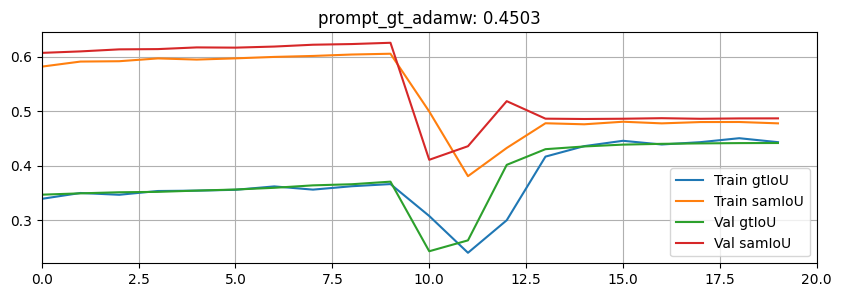

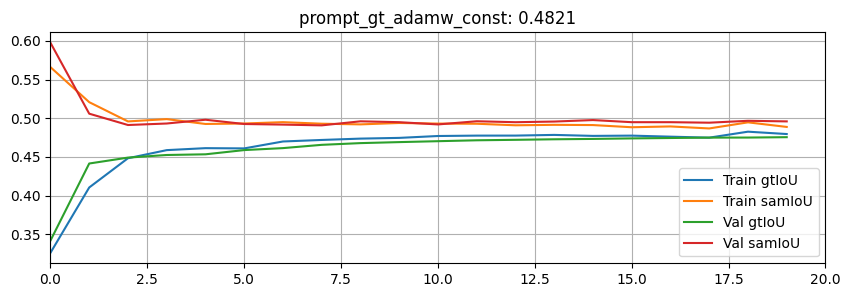

In [18]:
plot_learning_curve(paths, scatter=False)